In [1]:
pip install keras_tuner

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 133 kB 5.0 MB/s 


In [2]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image, ImageOps
import scipy.io
import pandas as pd
import cv2 as cv
import re
import os
import keras
import time
import pickle
import random
import shutil

import seaborn as sns
from sklearn.metrics import confusion_matrix
import keras_tuner as kt
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
import matplotlib.image as mpimg
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from keras.utils import np_utils
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from glob import glob
from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from statistics import mean

In [3]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Sun May 29 09:12:22 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   57C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
from tensorflow.python.client.device_lib import list_local_devices
print(list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 9576950349065089092
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 14465892352
locality {
  bus_id: 1
  links {
  }
}
incarnation: 6785723793241148084
physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
xla_global_id: 416903419
]


In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
path_img = "/content/drive/MyDrive/OpenClassRooms/Projet 6/Images_10"

Notre jeu de données contient 10 races de chien
Notre jeu de données contient un total de 1805 images
En moyenne chaque race de chien contient 180 images
Les differentes races de chien ont un nombre d'images allant de 151 à 239


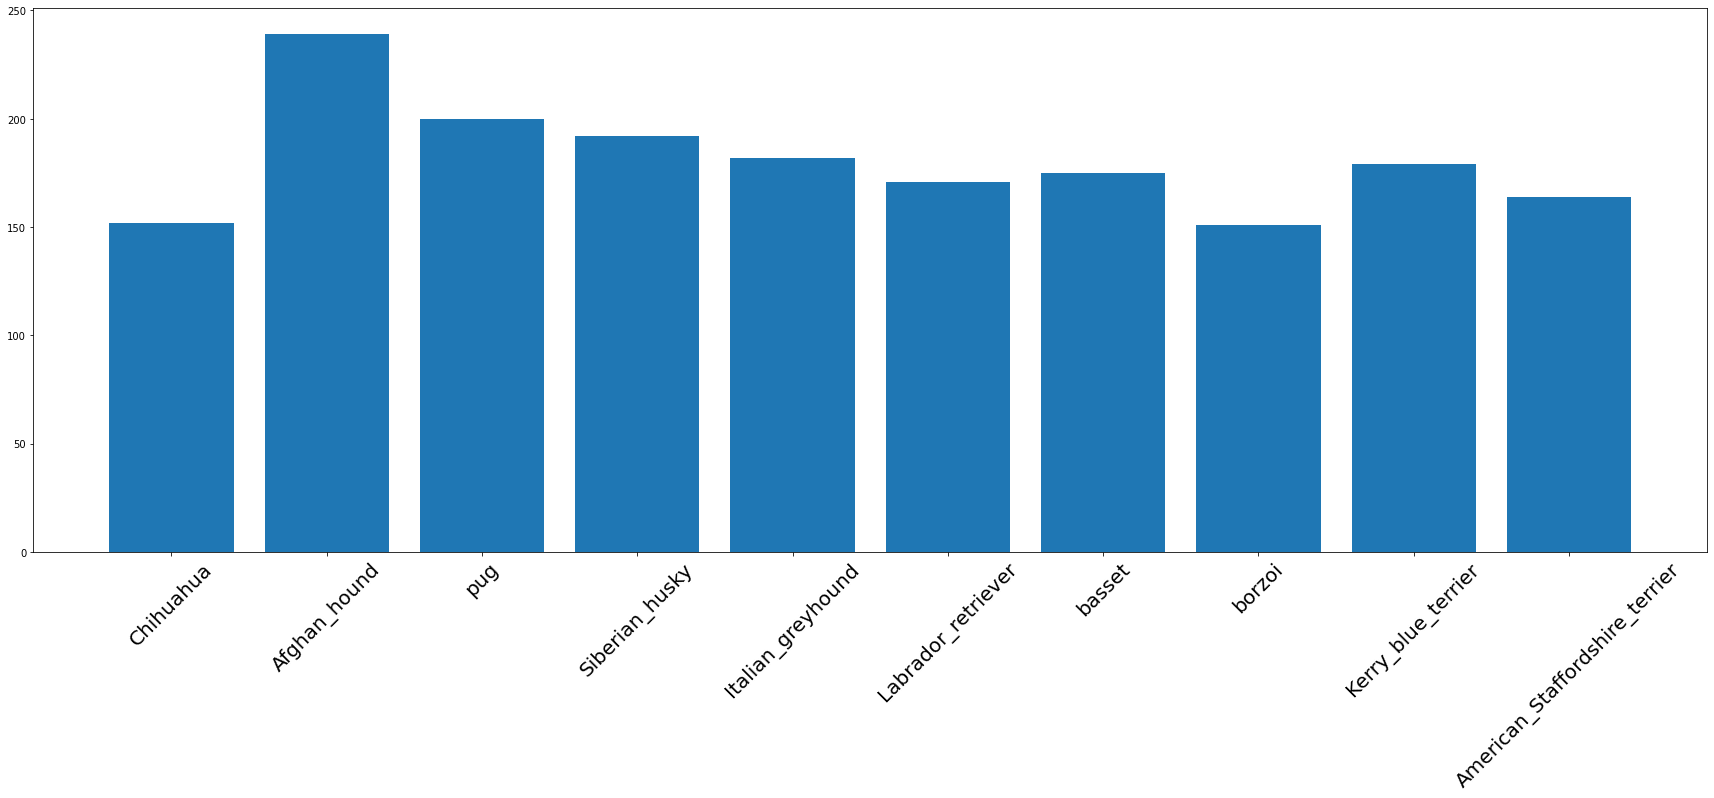

In [7]:
breed_list = []
breed_occurence = []

for path_breed in os.listdir(path_img):
    occurence = len(os.listdir(os.path.join(path_img, path_breed)))
    breed_list.append(path_breed.split('-')[1])
    breed_occurence.append(occurence)

plt.figure(figsize=(30,10))
plt.bar(x = breed_list, height = breed_occurence)
plt.xticks(rotation = 45, fontsize = 20);

print(f"Notre jeu de données contient {len(breed_list)} races de chien")
print(f"Notre jeu de données contient un total de {sum(breed_occurence)} images")
print(f"En moyenne chaque race de chien contient {round(mean(breed_occurence))} images")
print(f"Les differentes races de chien ont un nombre d'images allant de {min(breed_occurence)} à {max(breed_occurence)}")

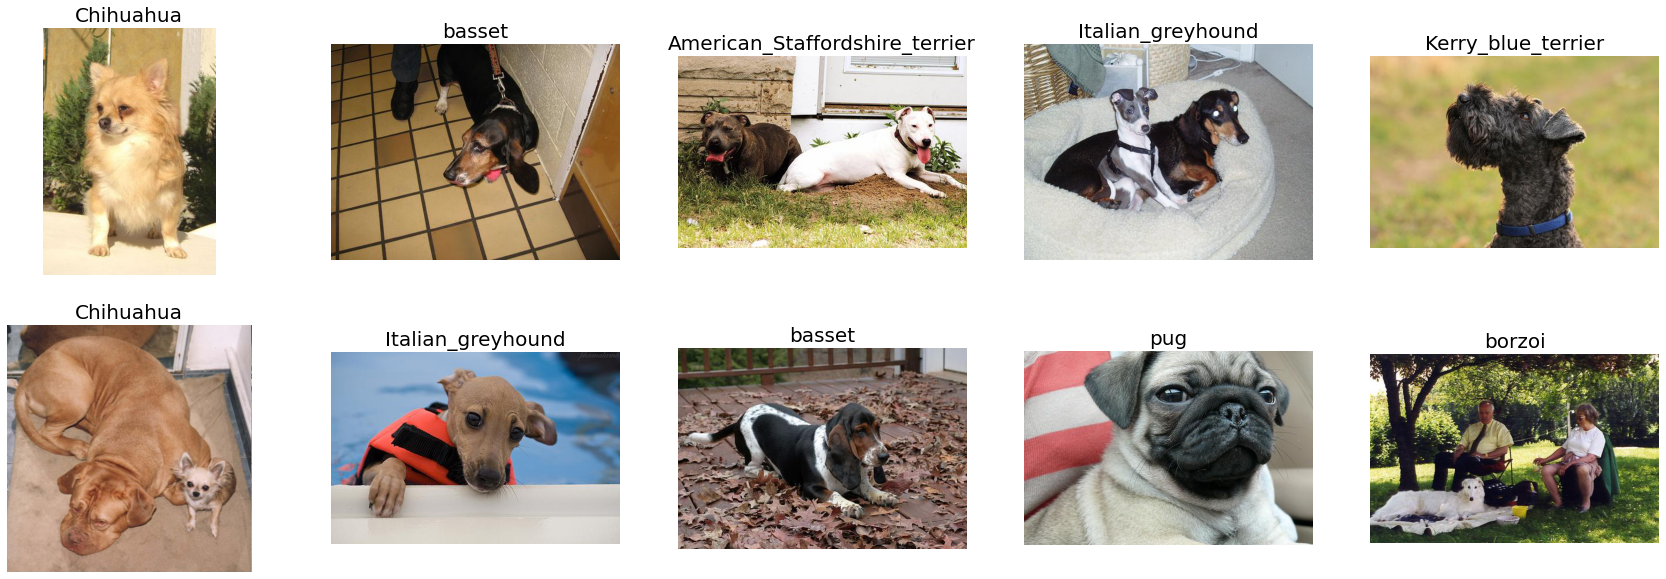

In [8]:
#affichage au hasard de 10 photos de chiens avec leur nom de race

plt.subplots(figsize=(30,10))
for i, path_breed in enumerate(np.random.choice(os.listdir(os.path.join(path_img)),10)):
  plt.subplot(2, 5, i+1)
  img = mpimg.imread(f"{path_img}/{path_breed}/{np.random.choice(os.listdir(os.path.join(path_img, path_breed)))}")
  plt.axis('off')
  plt.imshow(img)
  plt.title(path_breed.split("-")[1], fontsize=20)


# Preprocessing

In [9]:
path_processed = "/content/drive/MyDrive/OpenClassRooms/Projet 6/Processed"

In [10]:
def resize2SquareKeepingAspectRation(img, size, interpolation):
  h, w = img.shape[:2]
  c = None if len(img.shape) < 3 else img.shape[2]
  if h == w: return cv.resize(img, (size, size), interpolation)
  if h > w: dif = h
  else:     dif = w
  x_pos = int((dif - w)/2.)
  y_pos = int((dif - h)/2.)
  if c is None:
    mask = np.zeros((dif, dif), dtype=img.dtype)
    mask[y_pos:y_pos+h, x_pos:x_pos+w] = img[:h, :w]
  else:
    mask = np.zeros((dif, dif, c), dtype=img.dtype)
    mask[y_pos:y_pos+h, x_pos:x_pos+w, :] = img[:h, :w, :]
  return cv.resize(mask, (size, size), interpolation)

In [11]:
def preprocess_cnn(src, dst, w,h):    

    for path_breed in tqdm(os.listdir(src)):
        os.makedirs(os.path.join(dst, path_breed.split('-')[1]), exist_ok=True)
        for jpg in os.listdir(os.path.join(src, path_breed)):
            img = mpimg.imread(os.path.join(src, path_breed, jpg)) # lire l'image en array
            img = resize2SquareKeepingAspectRation(img, 255, cv.INTER_LINEAR) # redimensionner l'image avec des bandes noires
            #equilization
            img_yuv = cv.cvtColor(img,cv.COLOR_RGB2YUV) #passage de RGB à YUV
            img_yuv[:,:,0] = cv.equalizeHist(img_yuv[:,:,0]) #egalisation d'histogramme du contraste
            img_equ = cv.cvtColor(img_yuv, cv.COLOR_YUV2RGB)  #passage à nouveau au format RGB
            img_jpg = Image.fromarray(img_equ)
            img_jpg.save(os.path.join(dst, path_breed.split('-')[1], jpg))          

In [12]:
# t0= time.time()
# preprocess_cnn(path_img, path_processed, 255, 255)
# print("Execution time :",time.time()-t0,"secondes")

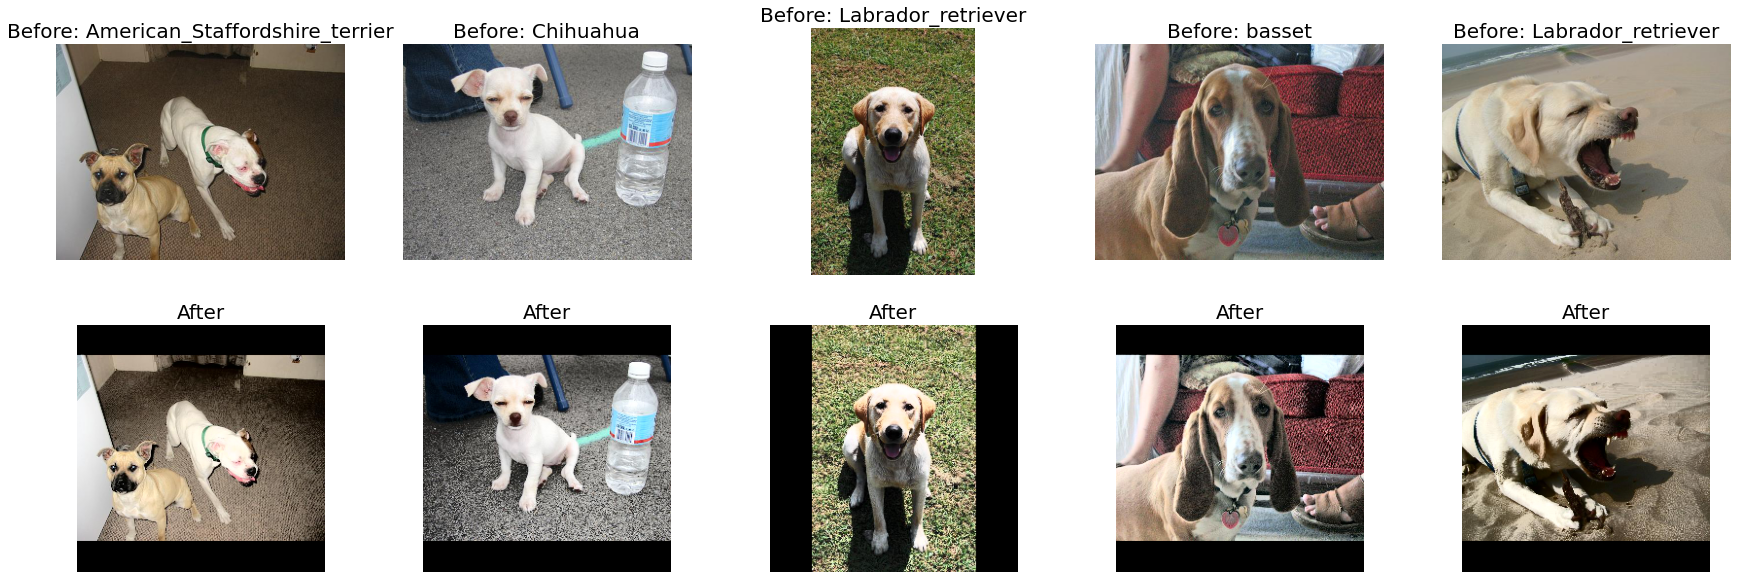

In [13]:
#affichage au hasard de 5 chiens avant et apres preprocessing
plt.subplots(figsize=(30,10))
for i, path_breed in enumerate(np.random.choice(os.listdir(os.path.join(path_img)),5)):
  
  ax1 = plt.subplot(2, 5, i+1)
  img = mpimg.imread(f"{path_img}/{path_breed}/{np.random.choice(os.listdir(os.path.join(path_img, path_breed)))}")
  plt.imshow(img)
  plt.axis('off')
  plt.title("Before: "+ path_breed.split("-")[1], fontsize=20)

  ax2 = plt.subplot(2, 5, i+6)
  img = resize2SquareKeepingAspectRation(img, 255, cv.INTER_LINEAR) # redimensionner l'image
  img_yuv = cv.cvtColor(img,cv.COLOR_RGB2YUV) #passage de RGB à YUV
  img_yuv[:,:,0] = cv.equalizeHist(img_yuv[:,:,0]) #egalisation d'histogramme du contraste
  img_equ = cv.cvtColor(img_yuv, cv.COLOR_YUV2RGB)  #passage à nouveau au format RGB
  plt.imshow(img_equ)
  plt.axis('off')
  plt.title("After", fontsize=20);

# *Train Test Split*

In [14]:
path_train = '/content/drive/MyDrive/OpenClassRooms/Projet 6/Train/'
path_test = '/content/drive/MyDrive/OpenClassRooms/Projet 6/Test/'

In [15]:
def folder_train_test_split(src, dst_train, dst_test):
  for path_breed in tqdm(os.listdir(src)):
    os.makedirs(os.path.join(dst_train, path_breed), exist_ok=True)
    os.makedirs(os.path.join(dst_test, path_breed), exist_ok=True)
    img_list = os.listdir(os.path.join(src, path_breed))
    random.shuffle(img_list)
    nb_files = len(img_list)
    nb_test = round(nb_files*0.2)
    train_list = img_list[:-nb_test]
    test_list = img_list[-nb_test:]
    for img in train_list:
      shutil.copy(os.path.join(src,path_breed,img), os.path.join(dst_train, path_breed, img))
    for img in test_list:
      shutil.copy(os.path.join(src,path_breed,img), os.path.join(dst_test, path_breed, img))

In [16]:
# t0= time.time()
# folder_train_test_split(path_processed, path_train, path_test)
# print("Execution time :",time.time()-t0,"secondes")

# *Modelisation*

In [17]:
NBCLASSES = len(os.listdir(path_train))
imsize = [255,255]
batch_size = 128

train_image_files = glob(path_train + '/*/*.jp*g')
test_image_files = glob(path_test + '/*/*.jp*g')

image_gen = ImageDataGenerator(
        rescale=1 / 255.0,
        rotation_range=20,
        zoom_range=0.05,
        width_shift_range=0.05,
        height_shift_range=0.05,
        shear_range=0.05,
        horizontal_flip=True,
        fill_mode="nearest",
        validation_split=0.20)


# create generators
train_generator = image_gen.flow_from_directory(
  path_train,
  target_size=imsize,
  shuffle=True,
  batch_size=batch_size
)

test_generator = image_gen.flow_from_directory(
  path_test,
  target_size=imsize,
  shuffle=True,
  batch_size=batch_size
)

indices_to_class = {value:key for key, value in train_generator.class_indices.items()}


Found 1737 images belonging to 10 classes.
Found 652 images belonging to 10 classes.


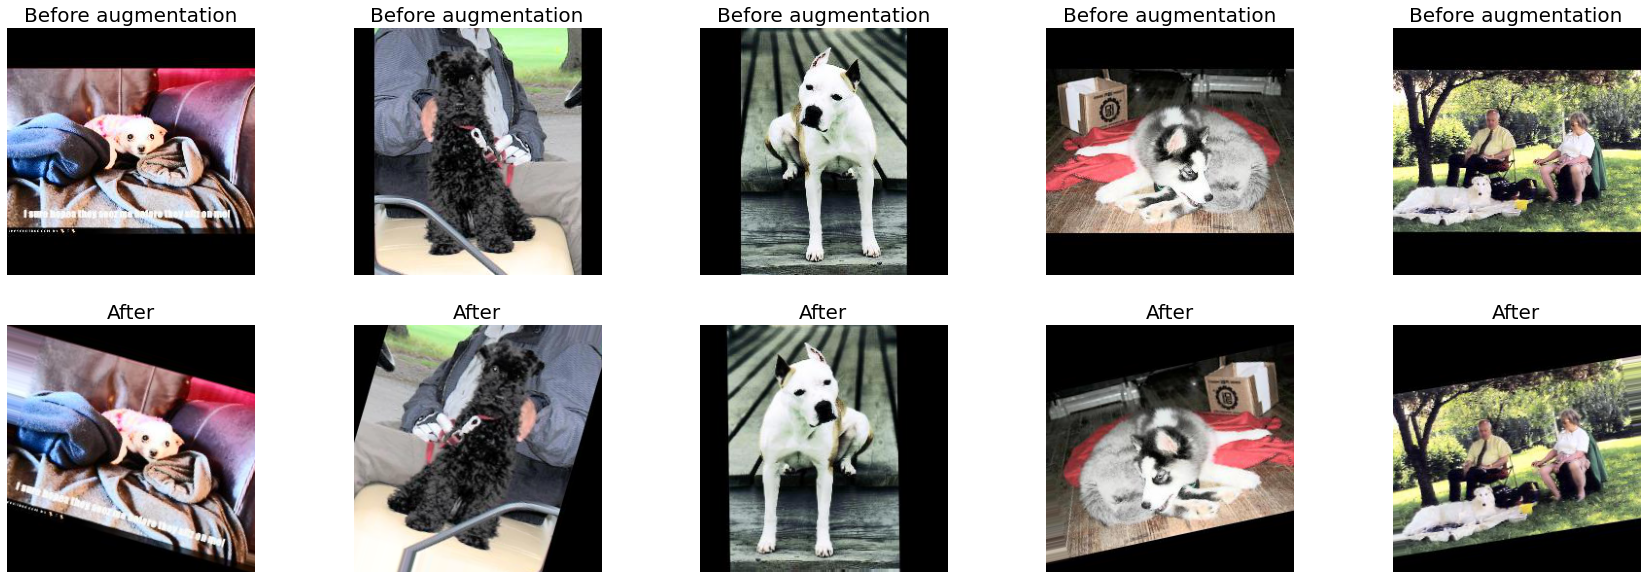

In [18]:
#affichage de 5 exemples avant et après generateur

exemple_image_files = glob(path_train + '/*/*.jp*g')
test_image_files = glob(path_test + '/*/*.jp*g')

plt.subplots(figsize=(30,10))
for i, path_breed in enumerate(np.random.choice(os.listdir(os.path.join(path_processed)),5)):
  
  ax1 = plt.subplot(2, 5, i+1)
  path_before = f"{path_processed}/{path_breed}/{np.random.choice(os.listdir(os.path.join(path_processed, path_breed)))}"
  img_before = mpimg.imread(path_before)
  plt.axis('off')
  plt.imshow(img_before)
  plt.title("Before augmentation", fontsize=20)

  ax2 = plt.subplot(2, 5, i+6)
  img_after = image_gen.flow(mpimg.imread(path_before).reshape(1,255,255,3))[0][0] #lire l'image transformée en array
  plt.imshow(img_after)
  plt.axis('off')
  plt.title("After", fontsize=20);

# *VGG16*

In [19]:
def create_vgg_model(hp):
    """Fonction pour la recherche d'hyperparamètres du modèle VGG"""
    vgg = VGG16(input_shape=imsize + [3], weights='imagenet', include_top=False)
 
    # Freeze existing VGG already trained weights
    for layer in vgg.layers:
        layer.trainable = False
     
    # get the VGG output
    out = vgg.output
     
    # Add new dense layer at the end
    x = Flatten()(out)
    for i in range(hp.Int('layers', 0, 2)):
      x = tf.keras.layers.Dense(units=hp.Choice('units_' + str(i), [256,512]),
                                    activation='relu')(x)
    x = keras.layers.Dropout(hp.Choice('dropout_rates', [0., 0.2]))(x)
    x = Dense(NBCLASSES, activation='softmax')(x)
     
    model = Model(inputs=vgg.input, outputs=x)
     
    model.compile(loss='categorical_crossentropy',
                  optimizer=tf.keras.optimizers.Adam(learning_rate=hp.Choice('learning_rates', [1e-3, 1e-4])),
                  metrics=['accuracy'])
     
    model.summary()
     
    return model

In [20]:
#création de l'instance tuner

vgg_tuner = kt.Hyperband(
    create_vgg_model,
    objective='val_accuracy',
    max_epochs=10,
    factor=3,
    overwrite=True)

early_stop = EarlyStopping(monitor='val_accuracy',patience=5)


58900480/58889256 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 255, 255, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 255, 255, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 255, 255, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 127, 127, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 127, 127, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 127, 127, 128)     147584    
                                                              

In [21]:
#lancement du tuner pour la recherche d'hp

vgg_tuner.search(train_generator, epochs=5, validation_data=test_generator, callbacks=[early_stop])


Trial 30 Complete [00h 06m 06s]
val_accuracy: 0.8665643930435181

Best val_accuracy So Far: 0.8680981397628784
Total elapsed time: 01h 24m 26s
INFO:tensorflow:Oracle triggered exit


In [22]:
#print des hyperparamètres retenus

vgg_best_hps=vgg_tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete. , the optimal number of layers is {vgg_best_hps.get('layers')},
the optimal dropout rate is {vgg_best_hps.get('dropout_rates')} and the optimal learning rate is {vgg_best_hps.get('learning_rates')}.
""")

for i in range(vgg_best_hps.get('layers')):
  print(f"""
The optimal number of units for densely-connected layer number {i+1} is {vgg_best_hps.get('units_' + str(i))})
""")
# The optimal number of units in the second to last densely-connected
# layer is {vgg_best_hps.get('dense_units')}


The hyperparameter search is complete. , the optimal number of layers is 2,
the optimal dropout rate is 0.2 and the optimal learning rate is 0.001.


The optimal number of units for densely-connected layer number 1 is 512)


The optimal number of units for densely-connected layer number 2 is 256)



In [23]:
#entraînement des hyperparamètres retenus

epochs = 20
early_stop = EarlyStopping(monitor='val_accuracy',patience=5)

t0= time.time()

vgg_model = vgg_tuner.hypermodel.build(vgg_best_hps)
vgg_history = vgg_model.fit(train_generator,
                            validation_data=test_generator,
                            epochs=epochs,
                            steps_per_epoch=len(train_image_files) // batch_size,
                            validation_steps=len(test_image_files) // batch_size,
                            callbacks=[early_stop])
vgg_val_acc_per_epoch = vgg_history.history['val_accuracy']
vgg_best_epoch = vgg_val_acc_per_epoch.index(max(vgg_val_acc_per_epoch)) + 1
print('Best epoch: %d' % (vgg_best_epoch,))

print("Execution time :",time.time()-t0,"secondes")


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 255, 255, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 255, 255, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 255, 255, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 127, 127, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 127, 127, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 127, 127, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 63, 63, 128)       0   

In [24]:
#sauvegarde du modèle dans le drive au format hdf5

tf.keras.models.save_model(
    vgg_model,
    "/content/drive/MyDrive/OpenClassRooms/Projet 6/vgg_model.hdf5",
    save_format = 'h5')

# *Lenet 5*

In [25]:
def create_lenet_model(hp):
    model = keras.models.Sequential([
    keras.layers.Conv2D(6, kernel_size=hp.Choice('kernel_sizes', [3,5]), strides=1,  activation='relu', input_shape=(255,255,3), padding='same'), #C1
    keras.layers.MaxPooling2D(), #S2
    keras.layers.Conv2D(16, kernel_size=hp.Choice('kernel_sizes', [3,5]), strides=1, activation='relu', padding='valid'), #C3
    keras.layers.MaxPooling2D(), #S4
    keras.layers.Conv2D(hp.Choice('conv_units', [64,128]), kernel_size=hp.Choice('kernel_sizes', [3,5]), strides=1, activation='relu', padding='valid'), #C5
    keras.layers.Flatten(), #Flatten    
    keras.layers.Dense(hp.Choice('dense_units', [32,64]), activation='relu'),
    keras.layers.Dropout(hp.Choice('dropout_rates', [0., 0.2])), #F6
    keras.layers.Dense(10, activation='softmax')]) #Output layer

    
    model.compile(loss='categorical_crossentropy',
                  optimizer=tf.keras.optimizers.Adam(learning_rate=hp.Choice('learning_rates', values=[1e-3, 1e-4])),
                  metrics=['accuracy'])

    model.summary()
     
    return model

In [26]:
#création de l'instance tuner

lenet_tuner = kt.Hyperband(
    create_lenet_model,
    objective='val_accuracy',
    max_epochs=10,
    factor=3,
    overwrite=True)

early_stop = EarlyStopping(monitor='val_accuracy',patience=5)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 255, 255, 6)       168       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 6)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 16)      880       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 16)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 64)        9280      
                                                                 
 flatten_2 (Flatten)         (None, 230400)            0

In [27]:
#lancement du tuner pour la recherche d'hp

lenet_tuner.search(train_generator, epochs=5, validation_data=test_generator, callbacks=[early_stop])


Trial 30 Complete [00h 05m 40s]
val_accuracy: 0.22239263355731964

Best val_accuracy So Far: 0.3052147328853607
Total elapsed time: 01h 08m 30s
INFO:tensorflow:Oracle triggered exit


In [28]:
#print des hyperparamètres retenus

lenet_best_hps=lenet_tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete. The optimal kernel size is {lenet_best_hps.get('kernel_sizes')},
the optimal number of units in the last convolution layer is {lenet_best_hps.get('conv_units')},
the optimal number of units in the last dense layer is {lenet_best_hps.get('dense_units')},
the optimal dropout rate is {lenet_best_hps.get('dropout_rates')} and the optimal learning rate for the optimizer is {lenet_best_hps.get('learning_rates')}.
""")




The hyperparameter search is complete. The optimal kernel size is 3,
the optimal number of units in the last convolution layer is 64,
the optimal number of units in the last dense layer is 64,
the optimal dropout rate is 0.2 and the optimal learning rate for the optimizer is 0.001.



In [29]:
#entraînement des hyperparamètres retenus

epochs = 20
early_stop = EarlyStopping(monitor='val_accuracy',patience=5)

t0= time.time()

lenet_model = lenet_tuner.hypermodel.build(lenet_best_hps)
lenet_history = lenet_model.fit(train_generator,
                            validation_data=test_generator,
                            epochs=epochs,
                            steps_per_epoch=len(train_image_files) // batch_size,
                            validation_steps=len(test_image_files) // batch_size,
                            callbacks=[early_stop])
lenet_val_acc_per_epoch = lenet_history.history['val_accuracy']
lenet_best_epoch = lenet_val_acc_per_epoch.index(max(lenet_val_acc_per_epoch)) + 1
print('Best epoch: %d' % (lenet_best_epoch,))

print("Execution time :",time.time()-t0,"secondes")


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 255, 255, 6)       168       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 127, 127, 6)      0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 125, 125, 16)      880       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 62, 62, 16)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 60, 60, 64)        9280      
                                                                 
 flatten_1 (Flatten)         (None, 230400)           

In [30]:
tf.keras.models.save_model(
    lenet_model,
    "/content/drive/MyDrive/OpenClassRooms/Projet 6/lenet_model.hdf5",
    save_format = 'h5')

# *SeparableConv2D layer*

In [31]:
def sep_conv_model(hp):
    model = keras.models.Sequential([
    keras.layers.SeparableConv2D(6, kernel_size=hp.Choice('kernel_sizes', [3,5]), strides=1,  activation='relu', input_shape=(255,255,3), padding='same'), #C1
    keras.layers.MaxPooling2D(), #S2
    keras.layers.SeparableConv2D(16, kernel_size=hp.Choice('kernel_sizes', [3,5]), strides=1, activation='relu', padding='valid'), #C3
    keras.layers.MaxPooling2D(), #S4
    keras.layers.SeparableConv2D(hp.Choice('conv_units', [64,128]), kernel_size=hp.Choice('kernel_sizes', [3,5]), strides=1, activation='relu', padding='valid'), #C5
    keras.layers.Flatten(), #Flatten    
    keras.layers.Dense(hp.Choice('dense_units', [32,64]), activation='relu'),
    keras.layers.Dropout(hp.Choice('dropout_rates', [0., 0.2])), #F6
    keras.layers.Dense(10, activation='softmax')]) #Output layer

    
    model.compile(loss='categorical_crossentropy',
                  optimizer=tf.keras.optimizers.Adam(learning_rate=hp.Choice('learning_rates', values=[1e-3, 1e-4])),
                  metrics=['accuracy'])

    model.summary()
     
    return model

In [32]:
#création de l'instance tuner

sep_conv_tuner = kt.Hyperband(
    sep_conv_model,
    objective='val_accuracy',
    max_epochs=10,
    factor=3,
    overwrite=True)

early_stop = EarlyStopping(monitor='val_accuracy',patience=5)


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 separable_conv2d (Separable  (None, 255, 255, 6)      51        
 Conv2D)                                                         
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 127, 127, 6)      0         
 2D)                                                             
                                                                 
 separable_conv2d_1 (Separab  (None, 125, 125, 16)     166       
 leConv2D)                                                       
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 62, 62, 16)       0         
 2D)                                                             
                                                                 
 separable_conv2d_2 (Separab  (None, 60, 60, 64)      

In [33]:
#lancement du tuner pour la recherche d'hp

sep_conv_tuner.search(train_generator, epochs=5, validation_data=test_generator, callbacks=[early_stop])

Trial 30 Complete [00h 05m 46s]
val_accuracy: 0.21932515501976013

Best val_accuracy So Far: 0.2730061411857605
Total elapsed time: 01h 11m 35s
INFO:tensorflow:Oracle triggered exit


In [34]:
#print des hyperparamètres retenus

sep_conv_best_hps=sep_conv_tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete. The optimal kernel size is {sep_conv_best_hps.get('kernel_sizes')},
the optimal number of units in the last convolution layer is {sep_conv_best_hps.get('conv_units')},
the optimal number of units in the last dense layer is {sep_conv_best_hps.get('dense_units')}
the optimal dropout rate is {sep_conv_best_hps.get('dropout_rates')} and the optimal learning rate for the optimizer is {sep_conv_best_hps.get('learning_rates')}.
""")



The hyperparameter search is complete. The optimal kernel size is 5,
the optimal number of units in the last convolution layer is 64,
the optimal number of units in the last dense layer is 64
the optimal dropout rate is 0.2 and the optimal learning rate for the optimizer is 0.001.



In [35]:
#entraînement du modèle retenu sur un plus grand nombre d'epochs

epochs = 20
early_stop = EarlyStopping(monitor='val_accuracy',patience=5)

t0= time.time()

sep_conv_model = sep_conv_tuner.hypermodel.build(sep_conv_best_hps)
sep_conv_history = sep_conv_model.fit(train_generator,
                            validation_data=test_generator,
                            epochs=epochs,
                            steps_per_epoch=len(train_image_files) // batch_size,
                            validation_steps=len(test_image_files) // batch_size,
                            callbacks=[early_stop])
sep_conv_val_acc_per_epoch = sep_conv_history.history['val_accuracy']
sep_conv_best_epoch = sep_conv_val_acc_per_epoch.index(max(sep_conv_val_acc_per_epoch)) + 1
print('Best epoch: %d' % (sep_conv_best_epoch,))

print("Execution time :",time.time()-t0,"secondes")

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 separable_conv2d_3 (Separab  (None, 255, 255, 6)      99        
 leConv2D)                                                       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 127, 127, 6)      0         
 2D)                                                             
                                                                 
 separable_conv2d_4 (Separab  (None, 123, 123, 16)     262       
 leConv2D)                                                       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 61, 61, 16)       0         
 2D)                                                             
                                                                 
 separable_conv2d_5 (Separab  (None, 57, 57, 64)      

In [36]:
tf.keras.models.save_model(
    sep_conv_model,
    "/content/drive/MyDrive/OpenClassRooms/Projet 6/sep_conv_model.hdf5",
    save_format = 'h5')

# *Modèle final*

In [44]:
score_vgg = vgg_model.evaluate(test_generator)
print('VGG Test loss:', score_vgg[0])
print('VGG Test accuracy:', score_vgg[1])

score_lenet = lenet_model.evaluate(test_generator)
print('Lenet Test loss:', score_lenet[0])
print('Lenet Test accuracy:', score_lenet[1])

score_sep_conv = sep_conv_model.evaluate(test_generator)
print('Sep Conv Test loss:', score_sep_conv[0])
print('Sep Conv Test accuracy:', score_sep_conv[1])



41/41 [==============================] - 10s 240ms/step - loss: 0.2590 - accuracy: 0.9387
VGG Test loss: 0.25901302695274353
VGG Test accuracy: 0.9386503100395203
41/41 [==============================] - 9s 223ms/step - loss: 1.9387 - accuracy: 0.3298
Lenet Test loss: 1.9387102127075195
Lenet Test accuracy: 0.3297545909881592
41/41 [==============================] - 9s 223ms/step - loss: 1.8466 - accuracy: 0.3558
Sep Conv Test loss: 1.8465826511383057
Sep Conv Test accuracy: 0.3558282256126404


In [43]:
#cellule à executer si nouveau kernel

vgg_model = keras.models.load_model("/content/drive/MyDrive/OpenClassRooms/Projet 6/vgg_model.hdf5")


# *Batch Size optimisation (essais)*

In [ ]:
def best_batchsize_model(hp):

    batch_size = hp.Choice('batch_sizes', [16,32,64,128,256])

    # create generators
    global train_generator_hp
    train_generator_hp = image_gen.flow_from_directory(
      path_train,
      target_size=imsize,
      shuffle=True,
      batch_size=batch_size
    )

    global test_generator_hp
    test_generator_hp = image_gen.flow_from_directory(
      path_test,
      target_size=imsize,
      shuffle=True,
      batch_size=batch_size
    )

    vgg = VGG16(input_shape=imsize + [3], weights='imagenet', include_top=False)
 
    # Freeze existing VGG already trained weights
    for layer in vgg.layers:
        layer.trainable = False
     
    # get the VGG output
    out = vgg.output
     
    # Add new dense layer at the end
    x = Flatten()(out)
    for i in range(vgg_best_hps.get('layers')):
      x = tf.keras.layers.Dense(units=vgg_best_hps.get('units_' + str(i)),
                                    activation='relu')(x)
    x = keras.layers.Dropout(vgg_best_hps.get('dropout_rates'))(x)
    x = Dense(NBCLASSES, activation='softmax')(x)
     
    model = Model(inputs=vgg.input, outputs=x)
     
    model.compile(loss='categorical_crossentropy',
                  optimizer=tf.keras.optimizers.Adam(learning_rate=vgg_best_hps.get('learning_rates')),
                  metrics=['accuracy'])
     
    model.summary()
     
    return model

In [ ]:
#création de l'instance tuner

best_batchsize_tuner = kt.Hyperband(
    best_batchsize_model,
    objective='val_accuracy',
    max_epochs=10,
    factor=3,
    overwrite=True)

early_stop = EarlyStopping(monitor='val_accuracy',patience=10)

In [ ]:
#lancement du tuner pour la recherche d'hp

best_batchsize_tuner.search(train_generator_hp, epochs=5, validation_data=test_generator_hp, callbacks=[early_stop])


In [ ]:
best_batchsize_hp=best_batchsize_tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""The hyperparameter search is complete. The optimal batch size is {best_batch_size_hp.get('batch_sizes')}""")

In [ ]:
batch_size = best_batch_size_hp.get('batch_sizes')

# create generators
train_generator = image_gen.flow_from_directory(
  path_train,
  target_size=imsize,
  shuffle=True,
  batch_size=batch_size
)

test_generator = image_gen.flow_from_directory(
  path_test,
  target_size=imsize,
  shuffle=True,
  batch_size=batch_size
)

In [39]:
#entraînement du modèle retenu sur un plus grand nombre d'epochs

epochs = 1000
early_stop = EarlyStopping(monitor='val_accuracy',patience=20)

t0= time.time()

vgg_model = vgg_tuner.hypermodel.build(vgg_best_hps)
vgg_history = vgg_model.fit(train_generator,
                            validation_data=test_generator,
                            epochs=epochs,
                            steps_per_epoch=len(train_image_files) // batch_size,
                            validation_steps=len(test_image_files) // batch_size,
                            callbacks=[early_stop])
vgg_val_acc_per_epoch = vgg_history.history['val_accuracy']
vgg_best_epoch = vgg_val_acc_per_epoch.index(max(vgg_val_acc_per_epoch)) + 1
print('Best epoch: %d' % (vgg_best_epoch,))

print("Execution time :",time.time()-t0,"secondes")

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 255, 255, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 255, 255, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 255, 255, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 127, 127, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 127, 127, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 127, 127, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 63, 63, 128)       0     

# *Pistes d'optimisations et entraînement final*

Confusion Matrix


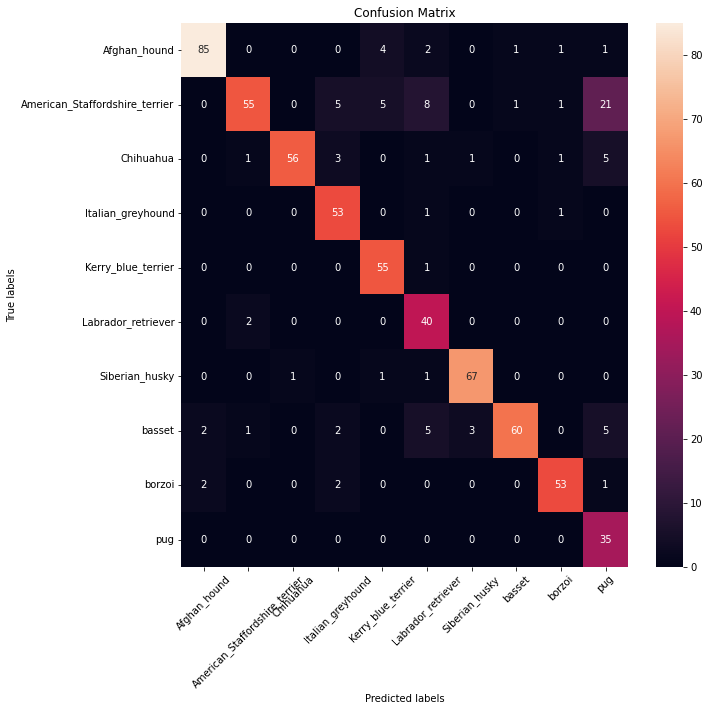

In [40]:
#création d'une matrice de confusion pour repérer les races les moins évidentes à prédire

X_test = np.zeros((len(test_image_files),255,255,3))
y_test = np.zeros(len(test_image_files))
for i in range(len(test_image_files)):
  X_test[i] = mpimg.imread(test_image_files[i])
  y_test[i] = train_generator.class_indices[test_image_files[i].split('/')[-2]]

y_pred_proba = vgg_model.predict(X_test)
y_pred = np.argmax(y_pred_proba, axis = 1)

print('Confusion Matrix')
cm = confusion_matrix(y_pred, y_test, labels = list(indices_to_class.keys()))

plt.figure(figsize=(10,10))
ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix');
ax.xaxis.set_ticklabels(indices_to_class.values(), rotation = 45); ax.yaxis.set_ticklabels(indices_to_class.values(), rotation = 0);

In [41]:
#entraînement du modèle retenu sur tout le dataset

total_generator = image_gen.flow_from_directory(
  path_processed,
  target_size=imsize,
  shuffle=True,
  batch_size=batch_size
)

total_image_files = glob(path_processed + '/*/*.jp*g')

epochs = 50

t0= time.time()

vgg_model = vgg_tuner.hypermodel.build(vgg_best_hps)
vgg_history = vgg_model.fit(total_generator,
                            validation_data=None,
                            epochs=epochs,
                            steps_per_epoch=len(total_image_files) // batch_size)

print("Execution time :",time.time()-t0,"secondes")

Found 1805 images belonging to 10 classes.
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 255, 255, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 255, 255, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 255, 255, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 127, 127, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 127, 127, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 127, 127, 128)     147584    
                                                                 
 block2_pool (Ma

KeyboardInterrupt: ignored

In [ ]:
#sauvegarde du modèle dans le drive au format hdf5

tf.keras.models.save_model(
    vgg_model,
    "/content/drive/MyDrive/OpenClassRooms/Projet 6/vgg_model.hdf5",
    save_format = 'h5')